# Reconstructing the evolution of an alpine karst system using conduit network model ensembles #

**Authors:** Chloé Fandel, Ty Ferré, François Miville, Philippe Renard, Nico Goldscheider.

**Keywords:** groundwater, modeling, karst, anisotropic fast marching, conduit networks, hypothesis testing, paleo-springs, karst evolution 

**Note:** Because this model has a stochastic element, each run is likely to be slightly different. The figures in this notebook will therefore not exactly match the published figures.


## Setup, imports, & functions ##
For development, import a local version of pykasso be able to make and test changes.
Import all other needed packages and local modules.
Define custom plotting functions.

In [1]:
#Import a local version of pyKasso by setting the path variable to the path to the local version 
#This allows reloading the module to see changes
import sys
sys.path.append('C:/Users/Chloe/Documents/GitHub/pyKasso/pykasso') #path to local version of package
import base as pk  #in this case, "base" is the name of the .py file with all of the pykasso functions in it

#Check that it worked:
#catchment = pk.SKS() #uncomment this line to create a simple model
#You should see a printed statement indicating that you are using a development version of the package.
#If you do not see this statement, you are using the main version, and changes you make to the local version will have no effect.

In [2]:
#Import the rest of the modules needed:
import os            
import sys           
import importlib
import copy
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import karstnet as kn

#all fast-marching-related imports
import agd
from agd import Eikonal
from agd.Metrics import Riemann

#Local modules:
import importlib.util
spec = importlib.util.spec_from_file_location('swmmpy', 'C:/Users/Chloe/Documents/GitHub/gottesacker/swmmpy.py')
sp = importlib.util.module_from_spec(spec)
spec.loader.exec_module(sp)

os.getcwd()

'C:\\Users\\Chloe\\Documents\\GitHub\\pyKasso\\notebooks'

In [3]:
#Define some custom functions for plotting:
def show_base(data, ax=None, plot_nodes=True, simplify=False, labels=[], title=None, cmap=None, color='k', alpha=1, legend=True):
        """
        Show the base network as a graph with nodes and edges.
        Inputs: 
        data:   path & name prefix to node and edge data files (ex: folder/subfolder/yournamehere. Files MUST be named 'yournamehere_nodes.dat', and 'yournamehere_links.dat')
        ax:     axis to plot on
        labels: None or list of strings ['nodes','edges'], indicating which components to label
        title:  string, title of plot
        cmap:   string, colormap to use when plotting
        color:  string, single color to use when plotting (cannot have both cmap and color)
        alpha:  float, opacity to plot with (1=opaque, 0=transparent)
        legend: True/False, whether to display legend
        plot_nodes:   True/False, whether to display nodes
        """

        if ax == None:
            fig,ax = plt.subplots(figsize=(10,10))
            ax.set_aspect('equal')
            
        #Set up data for plotting:
        if simplify == True:
            k = kn.from_nodlink_dat(os.path.join(data_path,ID+'SKS'))   #load karstnet graph from files
            nodes_complex = k.pos2d             #get dic of coordinates of all nodes in complex graph
            nodes_simple  = k.graph_simpl.nodes  #get indices of only the nodes in the simplified graph
            nodes_simple  = {node:[nodes_complex[node][1],nodes_complex[node][0]]  for node in nodes_simple}   #make df of only the nodes in the simplified graph, for plotting
            edges_simple  = k.graph_simpl.edges  #get only the edges in the simplified graph
            edges_simple  = {i: edge for i,edge in enumerate(edges_simple)}   #make df of only the edges in the simplified graph, for p
            nodes = pd.DataFrame.from_dict(nodes_simple, orient='index', columns=['x','y']) #convert to pandas for easier plotting
            edges = pd.DataFrame.from_dict(edges_simple, orient='index', columns=['inNode','outNode'])
        else:
            nodes  = pd.read_csv(data+'_nodes.dat', header=None, names=['y','x','z'], delim_whitespace=True) #import node data from ASCII file
            edges  = pd.read_csv(data+'_links.dat', header=None, names=['inNode','outNode'], delim_whitespace=True) #import edge data
            edges         = edges - 1               #convert from 1-based indexing to 0-based indexing
            
        fromX = nodes.x.loc[edges.inNode]       #calculate coordinates for link start and end points
        fromY = nodes.y.loc[edges.inNode]
        toX   = nodes.x.loc[edges.outNode]
        toY   = nodes.y.loc[edges.outNode]

        #Plot nodes and edges:
        if plot_nodes:
            n = ax.scatter(nodes.y,              nodes.x,                  c='k',         alpha=alpha, s=5)  #scatterplot nodes
        e = matplotlib.lines.Line2D([0],[0], c=color)                                                  #line artist for legend 
        for ind in edges.index:                                                               #loop over edge indices
            if cmap is not None:
                ax.plot((fromY.iloc[ind], toY.iloc[ind]), (fromX.iloc[ind], toX.iloc[ind]), c=plt.cm.get_cmap(cmap)(ind/len(edges)), alpha=alpha)  #plot each edge, moving along color gradient to show order
            elif color is not None:
                ax.plot((fromY.iloc[ind], toY.iloc[ind]), (fromX.iloc[ind], toX.iloc[ind]), c=color, alpha=alpha)  #plot each edge in same color
        
        #Add labels:
        if labels == None:
            pass
        else:
            if 'nodes' in labels:                                         #label node indices
                for ind in nodes.index:                                   #loop over node indices
                    ax.annotate(str(ind), xy=(nodes.y[ind]-10, nodes.x[ind]))  #annotate slightly to left of each node
            if 'edges' in labels:                                         
                for ind in edges.index:                                   
                    ax.annotate(str(ind), xy=(edges.y[ind]-10, edges.x[ind]))  #annotate slightly to left of each edge

        #Add legend & title:
        if legend:
            if plot_nodes:
                ax.legend([n,e],['nodes','edges'])
            else:
                ax.legend([e],['edges'])
        if title is not None:
            ax.set_title(title, fontsize=16)

        return None
    
def point2index(point, xmin,ymin,zmin, dx,dy,dz):
    '''Convert from x,y,z coordinates to i,j,k indices.'''
    x   = point[0]
    y   = point[1]
    z   = point[2]
    col = int((x - xmin) // dx)
    row = int((y - ymin) // dy)
    lay = int((z - zmin) // dz)
    
    return [col, row, lay]

## Gottesacker/Schwarzwassertal karst system ##
The extensively-studied Gottesacker/Schwarzwassertal karst system is located in the German/Austrian Alps (Goldscheider, 2005). This system consists of a series of plunging synclines and anticlines draining to the Schwarzwasser stream valley, which cuts roughly perpendicularly across the fold axes. The karst aquifer lies north of the valley in a limestone unit overlain by sandstone and underlain by non-karstifiable marl and older units (several other units are present, but for the purposes of conduit modeling, the geology has been simplified to only these four). Three major springs drain the system. South of the valley, unkarstifiable lithology prevents conduit development.

### Reference map of entire system ###
Settings from Paper 2

CAUTION: You are using the development version of this package.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd


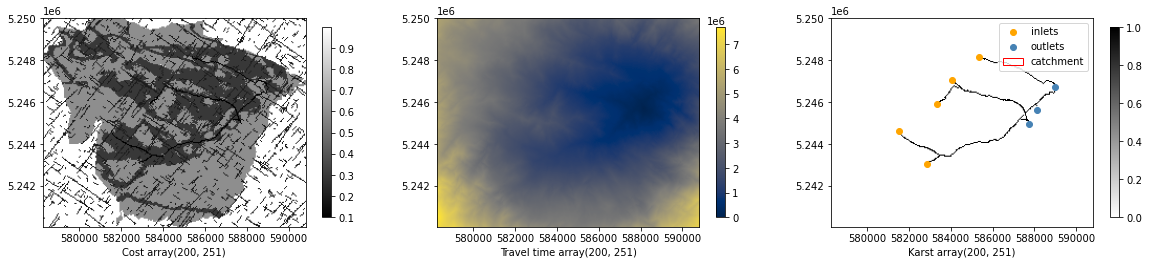

In [211]:
#Load model and simulate anisotropic network with multiple springs:
catchment = pk.SKS('inputs/gottesacker/settings.yaml')          #import settings and options from input folder
catchment.set_algorithm('Riemann2')                             #set algorithm to 2D anisotropic
catchment.set_fractures_mode('random')                          #generate a random fracture network 
catchment.set_rand_seed(0)                                      #get a different random choice each model run (set to 1 to keep same result each run)
catchment.set_outlets_data('inputs/gottesacker/outlets2D.txt')  #load a new outlet file with all outlets
catchment.set_outlets_importance([1,1,1])                       #assign each outlet to its own iteration
catchment.set_inlets_per_outlet([2,2,1])                        #assign first two inlets to first outlet, next two inlets to second outlets, and last inlet to last outlet.
catchment.set_inlets_importance([1])                            #assign all inlets for each outlet to a single iteration
#catchment.set_data_has_polygon(True)                            #add a polygon defining the catchment boundaries
#catchment.set_polygon_data('inputs/paper3/polygon.txt')         #set path to polygon
catchment.update_all()                                          #update model for changes to take effect
catchment.compute_karst_network()                               #run the model to calculate the karst network
catchment.show()

Geology array: (200, 251, 52) 0 4


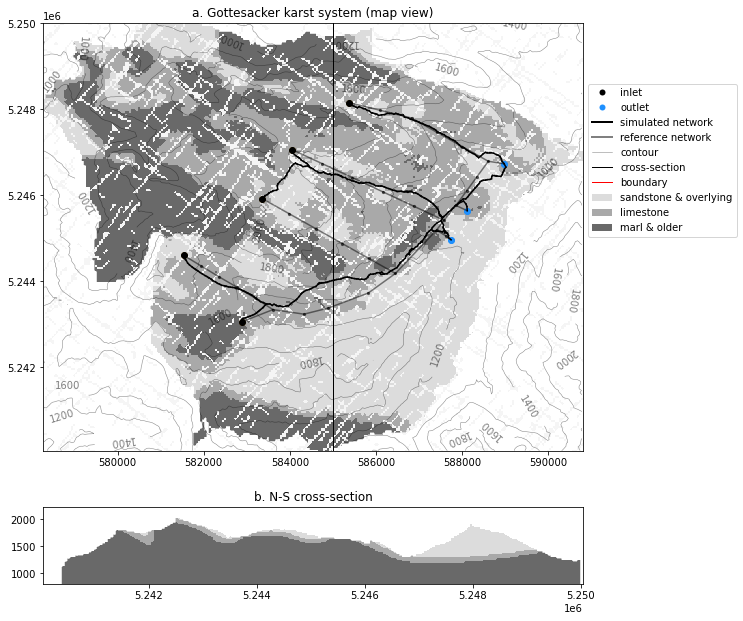

In [212]:
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(211, aspect='equal', position= [0, 0.6, 0.75, 0.75])  #[left, bottom, width, height]
ax.set_title('a. Gottesacker karst system (map view)')

cmap_geo = matplotlib.colors.ListedColormap(['white','gainsboro','darkgrey','dimgrey','dimgrey'])   #geology colormap
cmap_frac = matplotlib.colors.ListedColormap(['whitesmoke'])                                        #fracture colormap
cmap_frac.set_under(color='w', alpha=0)                                                             #set values under limit to transparent
frac = catchment.geology.data['fractures']['data'].copy()                                           #get fracture array
frac[frac<1] = -1                                                                                   #set all non-fracture cells under limit (prevents them from displaying)

plt.imshow(catchment.geology.data['geology']['data'], origin='lower', extent=catchment.grid.extent, cmap=cmap_geo)
c = plt.contour(catchment.grid.X,catchment.grid.Y, catchment.geology.data['topography']['data'], colors=['k'], alpha=0.5, linewidths=0.5)
plt.clabel(c, inline=True, inline_spacing=20, fontsize=10, fmt='%1.0f', rightside_up=False, use_clabeltext=True)
plt.imshow(frac,                                      origin='lower', extent=catchment.grid.extent, cmap=cmap_frac,     vmin=0,vmax=1)
show_base(data='inputs/gottesacker/base', ax=ax, legend=False, alpha=0.5)                                                 #plot base network
catchment.show_network(ax=ax, data=catchment.karst_simulations[0], simplify=False, labels=[], plot_nodes=False, legend=False, color='k')
plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')  
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')

section = 585000.0                                                                        #choose a cross-section location
plt.plot([section,section],[catchment.grid.ymin,catchment.grid.ymax], c='k', lw=1)        #uncomment to plot x-sec location

legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='k', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='dodgerblue', markeredgecolor='none', label='outlet'),
          matplotlib.lines.Line2D([0], [0], color='k',    lw=2,   label='simulated network'),
          matplotlib.lines.Line2D([0], [0], color='gray', lw=2,   label='reference network'),
          matplotlib.lines.Line2D([0], [0], color='gray', lw=0.5, label='contour'),
          matplotlib.lines.Line2D([0], [0], color='k',    lw=1,   label='cross-section'),
          matplotlib.lines.Line2D([0], [0], color='r',    lw=1,   label='boundary'),
          matplotlib.patches.Patch(facecolor='gainsboro', label='sandstone & overlying'),
          matplotlib.patches.Patch(facecolor='darkgray',  label='limestone'),
          matplotlib.patches.Patch(facecolor='dimgrey',   label='marl & older')]
plt.legend(handles=legend, loc=[1.01,0.5]) #to put on right side: loc=[1.01,0.5], to put in right corner: loc=[0.72,0.01], to put in left corner: loc=[0.01,0.01]


#Cross-section
##############################
run = True    #change to True to view cross-section
if run == True:
    ax2 = f.add_subplot(212, aspect='equal', anchor='N', position= [0, 0.35, 0.75, 0.25])
    plt.title('b. N-S cross-section')

    #Get data:
    zmin = 800;       znum = 52;   dz = 27.5;  zmax = zmin + znum*dz   #define system grid in the z direction
    geo = pd.read_csv('inputs/gottesacker/geo200x251x52.gslib', skiprows=2)  #read in gslib file to pandas df without header rows
    geo = geo.values
    geo = np.reshape(geo,(catchment.grid.ynum,catchment.grid.xnum,znum),order='F') #reshape to xyz grid using Fortran ordering
    print('Geology array:', geo.shape, geo.min(), geo.max())  
    [ix,iy,iz] = point2index([section,0,0],  
                             catchment.grid.xmin, catchment.grid.ymin, zmin, 
                             catchment.grid.dx,   catchment.grid.dy,   dz)  #get index of cross-section location
    plt.imshow(np.rot90(geo[:,ix,:],k=-1), origin='lower', extent=[catchment.grid.ymin,catchment.grid.ymax, zmin,zmax], cmap=cmap_geo)

## Focus area ##

In [104]:
#Convert exported files from ArcMap (raster to ASCII tool) to correct orientation and format for pyKasso:
#Only need to do this once.
run = False
if run == True:
    #DEM
    d = np.loadtxt('inputs/paper3/dem181x141.txt')  #load raw text file
    d[d==-9999]=0                                   #replace -9999 with 0 for nan values
    #d = np.flipud(np.rot90(d))                      #re-orient
    d = np.flipud(d)                                #re-orient
    plt.imshow(d, origin='lower')
    print(d.shape, np.unique(d))
    np.savetxt('inputs/paper3/dem181x141.csv', d, delimiter=',') #save as csv

    #Geology from ArcMap
    g = np.loadtxt('inputs/paper3/geo181x141.txt')  #load raw text file
    g[g==-9999]=0                                   #replace -9999 with 0 for nan values
    #g = np.flipud(np.rot90(g))                      #re-orient
    g = np.flipud(g)                                #re-orient
    plt.imshow(g, origin='lower')
    print(g.shape, np.unique(g))
    np.savetxt('inputs/paper3/geo181x141.csv', g, delimiter=',') #save as csv
    
    #Geology from GemPy
    g = np.loadtxt('inputs/paper3/gempy181x141.txt')  #load raw text file
    g[g==-9999]=0                                   #replace -9999 with 0 for nan values
    #g = np.flipud(np.rot90(g))                      #re-orient
    g = np.flipud(g)                                #re-orient
    plt.imshow(g, origin='lower')
    print(g.shape, np.unique(g))
    np.savetxt('inputs/paper3/gempy181x141.csv', g, delimiter=',') #save as csv
    
    #Faults:
    faults = np.loadtxt('inputs/paper3/faults181x141.csv', delimiter=',')  #load raw csv file
    matplotlib.image.imsave('inputs/paper3/faults181x141.png', faults, cmap='gray_r') #convert to png image

CAUTION: You are using the development version of this package.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd


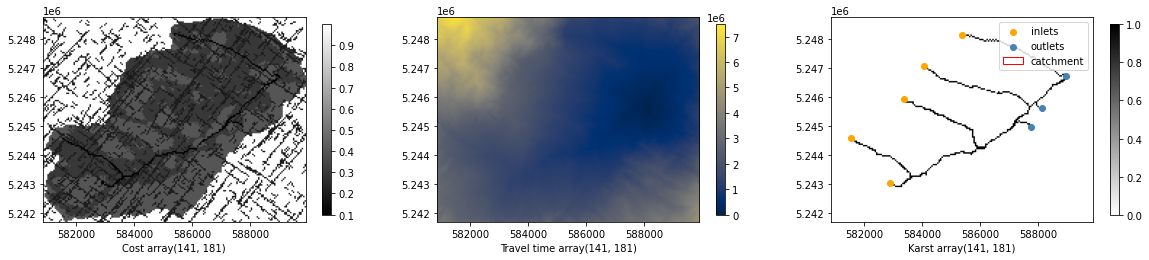

In [225]:
#Load model and simulate anisotropic network with multiple springs:
catchment = pk.SKS('inputs/paper3/settings.yaml')          #import settings and options from input folder
catchment.compute_karst_network()                          #run the model to calculate the karst network
catchment.show()

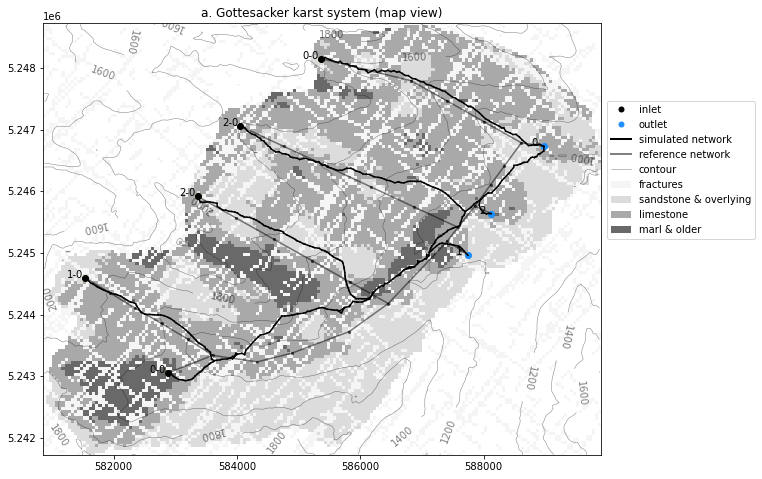

In [226]:
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111, aspect='equal')  
ax.set_title('a. Gottesacker karst system (map view)')

faults = catchment.get_faults().copy()                                           #get faults array
faults[faults<1] = -1                                                            #set non-fault cells to not display
frac = catchment.get_fractures().copy()                                           #get faults array
frac[frac<1] = -1                                                            #set non-fault cells to not display


plt.imshow(catchment.geology.data['geology']['data'], origin='lower', extent=catchment.grid.extent, cmap=cmap_geo)
plt.imshow(faults,                                    origin='lower', extent=catchment.grid.extent, cmap=cmap_frac,     vmin=0,vmax=1)
plt.imshow(frac,                                      origin='lower', extent=catchment.grid.extent, cmap=cmap_frac,     vmin=0,vmax=1)
c = plt.contour(catchment.grid.X,catchment.grid.Y, catchment.geology.data['topography']['data'], colors=['k'], alpha=0.5, linewidths=0.5)
plt.clabel(c, inline=True, inline_spacing=20, fontsize=10, fmt='%1.0f', rightside_up=False, use_clabeltext=True)
show_base(data='inputs/gottesacker/base', ax=ax, legend=False, alpha=0.5)                                                 #plot base network
catchment.show_network(ax=ax, data=catchment.karst_simulations[0], simplify=False, labels=['outlets', 'inlets'], plot_nodes=False, legend=False, color='k')
plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')  
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')

legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='k', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='dodgerblue', markeredgecolor='none', label='outlet'),
          matplotlib.lines.Line2D([0], [0], color='k',    lw=2,   label='simulated network'),
          matplotlib.lines.Line2D([0], [0], color='gray', lw=2,   label='reference network'),
          matplotlib.lines.Line2D([0], [0], color='gray', lw=0.5, label='contour'),
          matplotlib.patches.Patch(facecolor='whitesmoke', label='fractures'),
          matplotlib.patches.Patch(facecolor='gainsboro', label='sandstone & overlying'),
          matplotlib.patches.Patch(facecolor='darkgray',  label='limestone'),
          matplotlib.patches.Patch(facecolor='dimgrey',   label='marl & older')]
plt.legend(handles=legend, loc=[1.01,0.5]) #to put on right side: loc=[1.01,0.5], to put in right corner: loc=[0.72,0.01], to put in left corner: loc=[0.01,0.01]


### Probability maps ###

In [227]:
#Iterate over many versions:
catchment = pk.SKS('inputs/paper3/settings.yaml')

n = 20                                      #number of iterations to calculate (caution: more than 10 is slow)
for i in range(n):
    #catchment.update_inlets()
    catchment.update_fractures()
    catchment.compute_karst_network() 


CAUTION: You are using the development version of this package.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean 

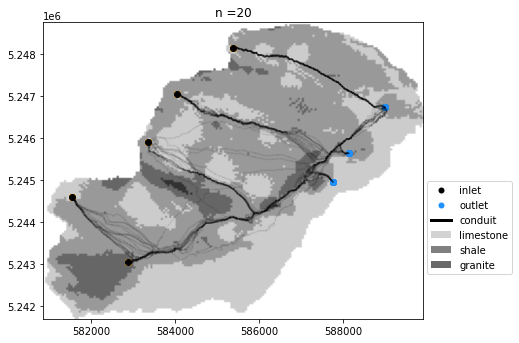

In [228]:
#Plot many iterations:
f = plt.figure(figsize=(15,15))

ax = f.add_subplot(111, aspect='equal')
ax.set_title('n ='+str(n))
plt.imshow(catchment.geology.data['geology']['data'], origin='lower', extent=catchment.grid.extent, cmap='gray_r', vmin=0,vmax=5)
#plt.imshow(catchment._compute_average_paths(), origin='lower', extent=catchment.grid.extent, cmap='gray_r')
for i in range(n):
    catchment.show_network(ax=ax, data=catchment.karst_simulations[i], simplify=False, labels=[], plot_nodes=False, legend=False, color='k', alpha=1/n)

plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')

legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='k', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='dodgerblue', markeredgecolor='none', label='outlet'),
          matplotlib.lines.Line2D([0], [0], color='k', lw=3,            label='conduit'),
          matplotlib.patches.Patch(facecolor='lightgray',  label='limestone'),
          matplotlib.patches.Patch(facecolor='gray',       label='shale'),
          matplotlib.patches.Patch(facecolor='dimgray',    label='granite')]
plt.legend(handles=legend, loc=[1.01,0.15])

## Hypothesis 1: glaciation ##
Only the overflow spring is active (all other springs covered by glacier).
Inlet N21 (farthest SW) is inactive (covered by glacier).
Inlet N1 is possibly inactive?

CAUTION: You are using the development version of this package.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd


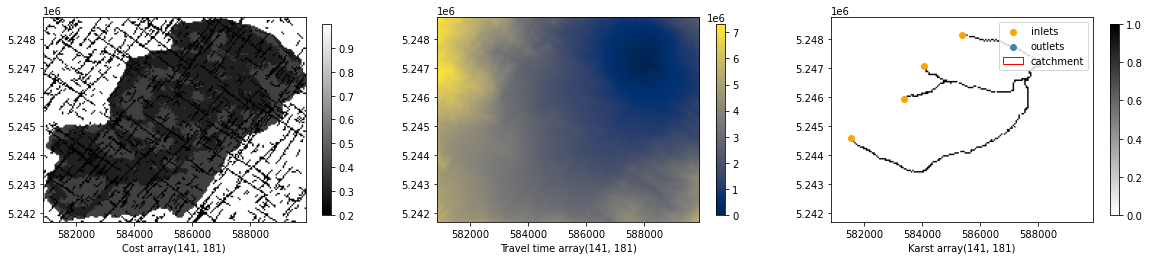

In [229]:
#Load model and simulate anisotropic network with multiple springs:
catchment = pk.SKS('inputs/paper3/settings.yaml')                     #import settings and options from input folder
catchment.set_inlets_data('inputs/paper3/inlets2D_hypothesis1.txt')   #load new inlet file
catchment.set_outlets_data('inputs/paper3/outlets2D_hypothesis1.txt') #load new outlet file
catchment.set_outlets_importance([1])                                 #only one outlet to iterate over
catchment.set_inlets_per_outlet([1])                                  #only one outlet to iterate over
catchment.set_inlets_importance([1])                                  #assign all inlets to a single iteration (4 inlets total)
catchment.update_all()                                                #update model for changes to take effect
catchment.compute_karst_network()                                     #run the model to calculate the karst network
catchment.show()

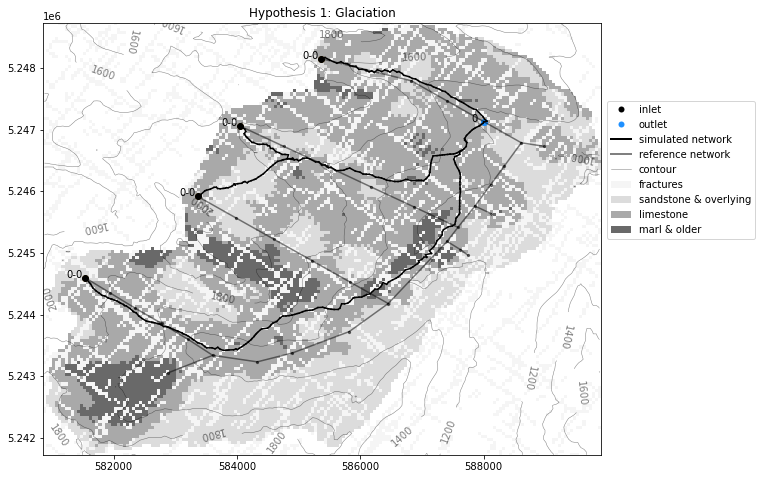

In [231]:
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111, aspect='equal')  
ax.set_title('Hypothesis 1: Glaciation')

faults = catchment.get_faults().copy()                                           #get faults array
faults[faults<1] = -1                                                            #set non-fault cells to not display
frac = catchment.get_fractures().copy()                                           #get faults array
frac[frac<1] = -1                                                            #set non-fault cells to not display


plt.imshow(catchment.geology.data['geology']['data'], origin='lower', extent=catchment.grid.extent, cmap=cmap_geo)
plt.imshow(faults,                                    origin='lower', extent=catchment.grid.extent, cmap=cmap_frac,     vmin=0,vmax=1)
plt.imshow(frac,                                      origin='lower', extent=catchment.grid.extent, cmap=cmap_frac,     vmin=0,vmax=1)
c = plt.contour(catchment.grid.X,catchment.grid.Y, catchment.geology.data['topography']['data'], colors=['k'], alpha=0.5, linewidths=0.5)
plt.clabel(c, inline=True, inline_spacing=20, fontsize=10, fmt='%1.0f', rightside_up=False, use_clabeltext=True)
show_base(data='inputs/gottesacker/base', ax=ax, legend=False, alpha=0.5)                                                 #plot base network
catchment.show_network(ax=ax, data=catchment.karst_simulations[0], simplify=False, labels=['outlets', 'inlets'], plot_nodes=False, legend=False, color='k')
plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')  
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')

legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='k', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='dodgerblue', markeredgecolor='none', label='outlet'),
          matplotlib.lines.Line2D([0], [0], color='k',    lw=2,   label='simulated network'),
          matplotlib.lines.Line2D([0], [0], color='gray', lw=2,   label='reference network'),
          matplotlib.lines.Line2D([0], [0], color='gray', lw=0.5, label='contour'),
          matplotlib.patches.Patch(facecolor='whitesmoke', label='fractures'),
          matplotlib.patches.Patch(facecolor='gainsboro', label='sandstone & overlying'),
          matplotlib.patches.Patch(facecolor='darkgray',  label='limestone'),
          matplotlib.patches.Patch(facecolor='dimgrey',   label='marl & older')]
plt.legend(handles=legend, loc=[1.01,0.5]) #to put on right side: loc=[1.01,0.5], to put in right corner: loc=[0.72,0.01], to put in left corner: loc=[0.01,0.01]


In [232]:
#Iterate over many versions:
catchment = pk.SKS('inputs/paper3/settings.yaml')
catchment.set_inlets_data('inputs/paper3/inlets2D_hypothesis1.txt')   #load new inlet file
catchment.set_outlets_data('inputs/paper3/outlets2D_hypothesis1.txt') #load new outlet file
catchment.set_outlets_importance([1])                                 #only one outlet to iterate over
catchment.set_inlets_per_outlet([1])                                  #only one outlet to iterate over
catchment.set_inlets_importance([1])                                  #assign all inlets to a single iteration (4 inlets total)

n = 10                                      #number of iterations to calculate (caution: more than 10 is slow)
for i in range(n):
    #catchment.update_inlets()
    #catchment.update_fractures()
    catchment.update_all()                                                #update model for changes to take effect
    catchment.compute_karst_network() 

CAUTION: You are using the development version of this package.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean 

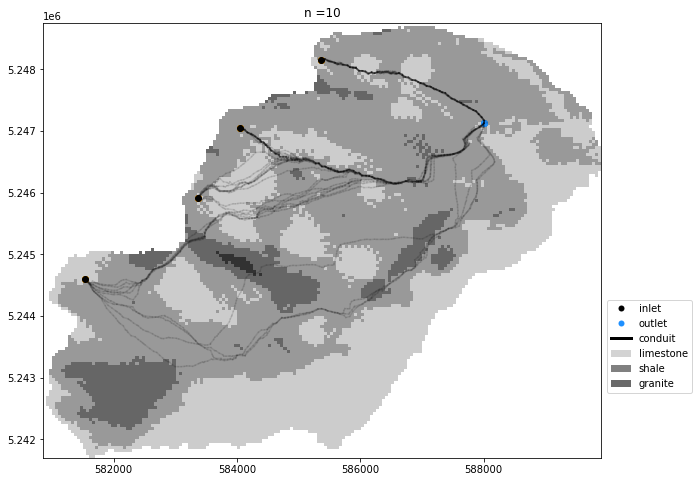

In [234]:
#Plot many iterations:
f = plt.figure(figsize=(10,10))

ax = f.add_subplot(111, aspect='equal')
ax.set_title('n ='+str(n))
plt.imshow(catchment.geology.data['geology']['data'], origin='lower', extent=catchment.grid.extent, cmap='gray_r', vmin=0,vmax=5)
#plt.imshow(catchment._compute_average_paths(), origin='lower', extent=catchment.grid.extent, cmap='gray_r')
for i in range(n):
    catchment.show_network(ax=ax, data=catchment.karst_simulations[i], simplify=False, labels=[], plot_nodes=False, legend=False, color='k', alpha=1/n)

plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')

legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='k', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='dodgerblue', markeredgecolor='none', label='outlet'),
          matplotlib.lines.Line2D([0], [0], color='k', lw=3,            label='conduit'),
          matplotlib.patches.Patch(facecolor='lightgray',  label='limestone'),
          matplotlib.patches.Patch(facecolor='gray',       label='shale'),
          matplotlib.patches.Patch(facecolor='dimgray',    label='granite')]
plt.legend(handles=legend, loc=[1.01,0.15])